In [1]:
#import need Modules
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model


# Read in images and create a dataframe of image paths and class labels

In [2]:
sdir = 'archive/portuguese_food_2'
file_paths = []
labels = []
class_list = sorted(os.listdir(sdir))   #排序
for klass in class_list:
    print ('Processing class ', klass)
    classpath=os.path.join(sdir, klass)
    flist=sorted(os.listdir(classpath))
    for f in flist:
        fpath=os.path.join(classpath,f)
        try: # earlier run showed there is at least one invalid image find it and do not put in dataframe
            img = cv2.imread(fpath)
            shape=img.shape
            if len(shape) != 3:
                print('Image file ', fpath, ' is not an rgb image and was not used in the dataframe')
            else:
                file_paths.append(fpath)            
                labels.append(klass) 
        except:
            print('Image file ', fpath, ' is an invalid image and was not used')
print(file_paths)
print(klass)
            
fseries = pd.Series(file_paths,name='file_paths')   #一维数组
Lseries = pd.Series(labels,name='labels')
df = pd.concat([fseries,Lseries],axis=1)
print(df['labels'])
train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels']) 
valid_df,test_df = train_test_split(dummy_df,
                                  train_size=.5,
                                  shuffle=True,
                                  stratify=dummy_df['labels'])
print(f'train lenght:{len(train_df)}\n test_df length:{len(test_df)}\nvalid_df length:{len(valid_df)}')
classes = sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print(' the number of classes in the dataset is :',class_count)
groups = train_df.groupby('labels')
print("{0:^30s}{1:^13s}".format('CLASS','IMAGE COUTN'))
count_list = []
class_list = []
for label in sorted(list(train_df['labels'].unique())):
    group = groups.get_group(label)
    count_list.append(len(group))
    class_list.append(label)
    print('{0:^30s}{1:^13s}'.format(label,str(len(group))))
max_value = np.max(count_list)
max_index = count_list.index(max_value)
max_class = class_list[max_index]
min_value = np.min(count_list)
min_index = count_list.index(min_value)
min_class = class_list[min_index]
print(max_class,'has the most image=',max_value,'\n',
     min_class,'has the most image=',min_value)
ht = 0
wt = 0
train_df_sample = train_df.sample(n=100,random_state=123,axis=0)
for i in range(len(train_df_sample)):
    fpath = train_df_sample['file_paths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    ht += shape[0]
    wt += shape[1]
print(wt)
print('average height=',ht//100,'average width=',wt//100,'aspeot ratio=',ht/wt)


Processing class  aletria
Processing class  arroz_cabidela
Processing class  bacalhau_bras
Processing class  bacalhau_natas
Processing class  batatas_fritas
Processing class  bolo_chocolate
Processing class  cachorro
Processing class  caldo_verde
Processing class  cozido_portuguesa
Processing class  croissant
Processing class  donuts
Processing class  esparguete_bolonhesa
Processing class  feijoada
Processing class  francesinha
Processing class  gelado
Processing class  hamburguer
Processing class  jardineira
Processing class  nata
Processing class  ovo
Processing class  pasteis_bacalhau
Processing class  pizza
Processing class  tripas_moda_porto
Processing class  waffles
['archive/portuguese_food_2\\aletria\\1.jpg', 'archive/portuguese_food_2\\aletria\\10.jpg', 'archive/portuguese_food_2\\aletria\\100.jpg', 'archive/portuguese_food_2\\aletria\\101.jpg', 'archive/portuguese_food_2\\aletria\\102.jpg', 'archive/portuguese_food_2\\aletria\\103.jpg', 'archive/portuguese_food_2\\aletria\\10

63250
average height= 567 average width= 632 aspeot ratio= 0.896901185770751


# Trim train_df so no class has more than 150 image samples

In [3]:
def trim(df,max_sample,min_sample,column):
    df = df.copy()
    groups = df.groupby(column)
    trimmed_df = pd.DataFrame(columns=df.columns)
    for label in df[column].unique():
        group = groups.get_group(label)
        count = len(group)
        if count > max_sample:
            sample_group = group.sample(n=max_sample,random_state=123,axis=0)
            trimmed_df = pd.concat([trimmed_df,sample_group],axis=0)
        else:
            if count > min_sample:
                sample_group = group
                trimmed_df = pd.concat([trimmed_df,sample_group],axis=0)
    print('after trimming,the maximum sample in any class is now',max_sample,'and the minum sample in any class is',min_sample)
    return trimmed_df
max_sample = 150
min_sample = 18
column='labels'
train_df = trim(train_df,max_sample,min_sample,column)

after trimming,the maximum sample in any class is now 150 and the minum sample in any class is 18


# Balance the train_df dataframe

In [4]:
def balance(df,n,working_dir,img_size):
    def augment(df,n,working_dir,img_size):
        aug_dir = os.path.join(working_dir,'aug')
        os.mkdir(aug_dir)
        for label in df['labels'].unique():
            dir_path = os.path.join(aug_dir,label)
            os.mkdir(dir_path)
        # create and store the augmented images
        total = 0
        gen = ImageDataGenerator(horizontal_flip=True,
                                 rotation_range=20,
                                 width_shift_range=.2,
                                 height_shift_range=0.2,
                                 zoom_range=.2)
        groups = df.groupby('labels')
        for label in df['labels'].unique():
            group = groups.get_group(label) # a dataframe holding only rows with the specified label 
            sample_count = len(group)# determine how many samples there are in this class  
            if sample_count < n:
                aug_img_count = 0
                delta = n -sample_count# number of augmented images to create
                target_dir = os.path.join(aug_dir)# define where to write the images
                msg = '{0:40s} for class:{1:^30s} creating {2:^50s} augmented image'.format(' ',label,str(delta))
                print(msg,'\r',end='')
#                 aug_gen=gen.flow_from_dataframe( group,  
#                                                 x_col='filepaths',
#                                                 y_col=None, 
#                                                 target_size=img_size,
#                                                 class_mode=None, 
#                                                 batch_size=1, 
#                                                 shuffle=False, 
#                                                 save_to_dir=target_dir,
#                                                 save_prefix='aug-', 
#                                                 color_mode='rgb',
#                                                 save_format='jpg')
                aug_gen = gen.flow_from_dataframe(group,
                                                  x_col='file_paths',
                                                  y_col=None,
                                                  target_size=img_size,
                                                  class_mode=None,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  save_to_dir=target_dir,
                                                  save_prefix='aur-',
                                                  color_mode='rgb',
                                                  save_format='jpg')
                while aug_img_count < delta:
                    images = next(aug_gen)
                    aug_img_count += len(images)
                total += aug_img_count
        print('Total Augmented images created=',total)
        # create aug_df and merge with train_df to create composite training set ndf
        aug_fpaths = []
        aug_labels = []
        classlist = os.listdir(aug_dir)
        for klass in classlist:
            classpath = os.path.join(aug_dir,klass)
            if os.path.exists(classpath):
                flist = classpath
            else:
                flist = os.mkdir(classpath)
                
            for f in flist:
                fpath = os.path.join(classpath,f)
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries = pd.Series(aug_fpaths,name='filepaths')
        Lseries = pd.Series(aug_labels,name='labels')
        aug_df = pd.concat([Fseries,Lseries],axis=1)
        df = pd.concat([df,aug_df],axis=0).reset_index(drop=True)
        print('Length of augmented dataframe is now ',len(df))
        return df
    df = df.copy()
    #print('Initial length of dataframe is',len(df))
    # make directories to store augmented images-
    aug_dir= os.path.join(working_dir,'aug')
    if 'aug' in os.listdir(working_dir):
        #print(' Augmented images already exist. To delete these and create new images enter D, else enter U to use these images',flush=True)
        ans = input(' ')
        if ans == 'D' or ans == 'd':
            shutil.rmtree(aug_dir) # start with an clean empty directory  
            return augment(df,n,working_dir,img_size)
        else:
            return df
    else:
        return augment(df,n,working_dir,img_size)
n=150 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(200,250) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

 d
Found 85 validated image filenames.      for class:      tripas_moda_porto        creating                         65                         augmented image 
Found 78 validated image filenames.      for class:          jardineira           creating                         72                         augmented image 
Found 78 validated image filenames.      for class:             nata              creating                         72                         augmented image 
Found 78 validated image filenames.      for class:        bacalhau_natas         creating                         72                         augmented image 
Found 89 validated image filenames.      for class:       pasteis_bacalhau        creating                         61                         augmented image 
Found 79 validated image filenames.      for class:           feijoada            creating                         71                         augmented image 
Found 78 validated image filenames.      fo

# Create the train_gen, test_gen final_test_gen and valid_gen

In [10]:
batch_size = 30# We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen = ImageDataGenerator(horizontal_flip=True,
                           rotation_range=20,
                           width_shift_range=.2,
                           height_shift_range=.2,
                           zoom_range=.2)
t_and_v_gen = ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_df['file_paths'] = train_df['file_paths'].astype(str)   #强制转换为字符串
train_gen=trgen.flow_from_dataframe(train_df, 
                                    x_col='file_paths', 
                                    y_col='labels', 
                                    target_size=img_size,
                                    class_mode='categorical',
                                    color_mode='rgb', 
                                    shuffle=True, 
                                    batch_size=batch_size)

msg='{0:70s} for valid generator'.format(' ') 
print(msg, '\r', end='') # prints over on the same line#\r 表示将光标的位置回退到本行的开头位置
valid_gen = t_and_v_gen.flow_from_dataframe(valid_df,
                                            x_col='file_paths',
                                            y_col='labels',
                                            targen_size=img_size,
                                            class_mode='categorical',
                                            color_mode='rgb',
                                            shuffle=False,
                                            batch_size=batch_size)
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n <80],
                                   reverse=True)[0]
test_steps = int(length/test_batch_size)
msg = '{0:70s} for test generator'.format(' ')
print(msg,'\r',end='')
test_gen = t_and_v_gen.flow_from_dataframe(test_df,
                                          x_col='file_paths',
                                          y_col='labels',
                                          target_size=img_size,
                                          class_mode='categorical',
                                          color_mode='rgb',
                                          shuffle=False,
                                          batch_size=test_batch_size)
# from the generator we can get information we will need later
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels
print('test batch size；',test_batch_size,'test steps ',test_steps,'number of classes：',class_count)


Found 2551 validated image filenames belonging to 22 classes.          for train generator 
Found 673 validated image filenames belonging to 23 classes.           for valid generator 
Found 673 validated image filenames belonging to 23 classes.           for test generator 
test batch size； 1 test steps  673 number of classes： 22


f:\python\py3.6\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 18866 invalid image filename(s) in x_col="file_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Create a function to show example training images

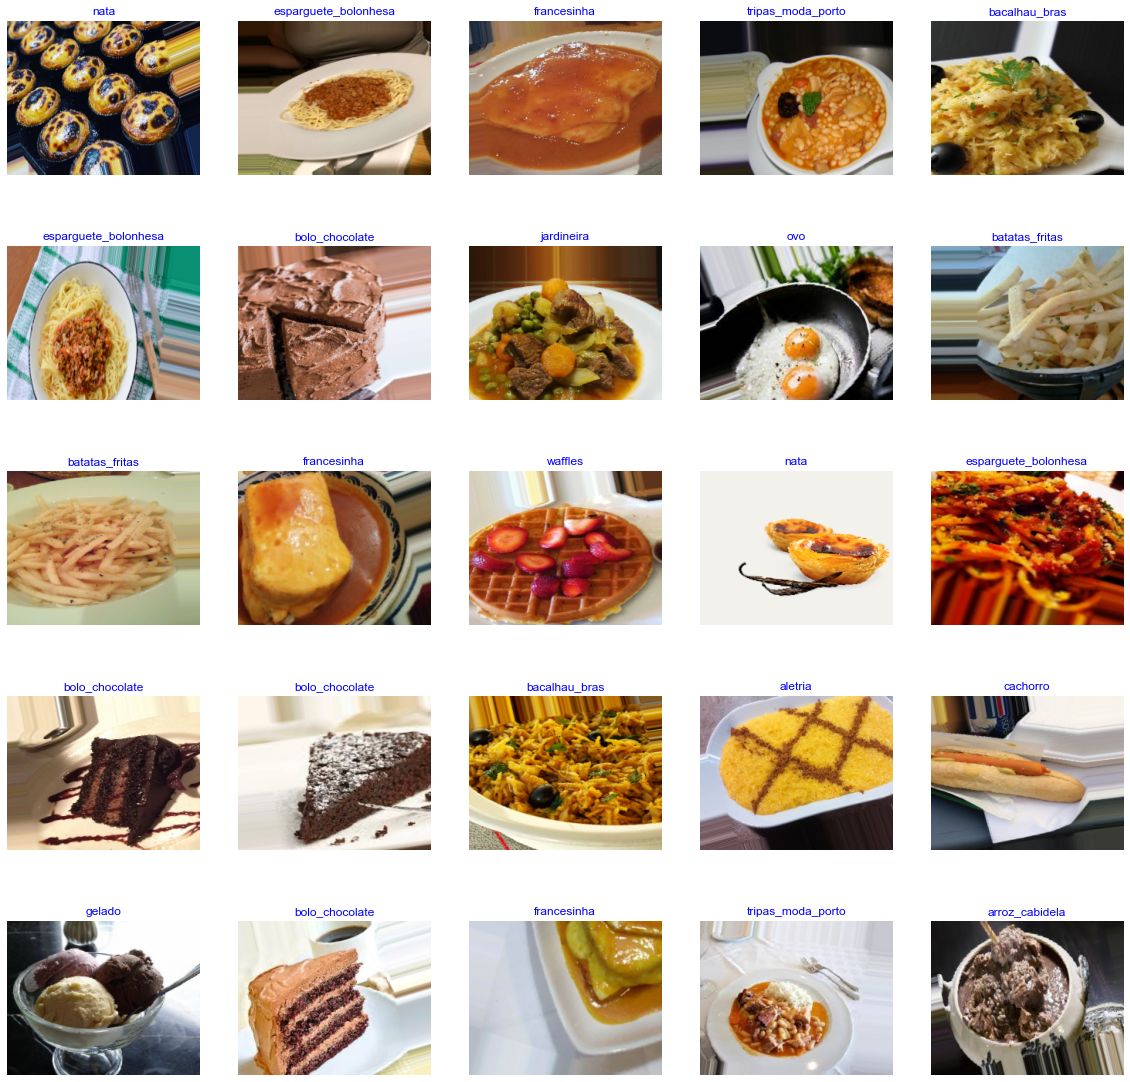

In [15]:
def show_image_sample(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images,labels = next(gen)
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length <25:
        r = length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image = images[i]/255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name,color='blue',fontsize=12)
        plt.axis('off')
    plt.show()
show_image_sample(train_gen)

# Create a model using transfer learning with EfficientNetB3

In [25]:
img_shape = (img_size[0],img_size[1],3)
model_name = 'EfficientNetB3'
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False,
                                                               weights='imagenet',
                                                               input_shape=img_shape,
                                                               pooling='max')
base_model.trainable=True
x = base_model.output
x = BatchNormalization(axis=1,momentum=0.99,epsilon=0.001)(x)
x = Dense(256,
          kernel_regularizer=regularizers.l2(0.016),
         activity_regularizer=regularizers.l1(0.006),
         bias_regularizer=regularizers.l1(0.006),
          activation='relu')(x)

x = Dropout(rate=.4,seed=123)(x)
output = Dense(class_count,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=output)
lr = .005
model.compile(Adamax(learning_rate=lr),
              loss='categorical_crossentropy',
                     metrics=['accuracy'])


# Create a custom Keras callback to continue and optionally set LR or halt training

In [34]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self,model,epochs,ask_epoch):
        super(LR_ASK,self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch=1
    
    def on_train_begin(self,logs=None):
        if self.ask_epoch==0:
            print(' you set ask_epoch=0,ask_eoch will be set to 1 ',flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs:# you are running for epochs but ask_epoch>epochs
            print(' ask_epoch  >= epochs,will train for ',epochs,'epochs',flush=True)
            self.ask=False
        if self.epochs==1:
            self.ask=False
        else:
            print( 'Training will proceed untill epoch',ask_epoch,'then you will be asked to ')
            print( 'enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()
        
    def on_train_end(self,logs=None):
        print('loading model with weights from epoch',slef.best_epoch)
        self.model.set_weights(self.best_weights)
        tr_duration = time.time()-self.start_time
        hours = tr_duration//3600
        minutes = (tr_duration-(hours*3600))//60
        seconds = (tr_duration-((hours*3600)+minutes*60))
        msg = f'training elapsed time wes {str(hours)} hours,{mintes:4.1f} mintutes,{seconds:4.2f},seconds'
        print(msg,flush=True)
    def on_epoch_end(self,epoch,logs=None):
        v_loss = logs.get('val_loss')# get the validation loss for this epoch
        if v_loss < self.lowest_vloss:
            self.lowest_vloss = v_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch += 1
            print(' \n validation loss reduced ,saving weight from epoch',epoch+1,'as best weight')
        if self.ask:
            if epoch + 1 ==self.ask_epoch:
                print('\nEnter h to end training or an integer for the nmber of additional epochs to run then ask agein')
                ans=input()
                if ans=='h' or ans =='H' or ans=='0':
                    print('you entered ',ans ,'Training halted on epoch',epoch+1,'due to user input \n',flush=Treu)
                    self.model.stop_training=True
                else:
                    self.ask_epoch+= int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\n You specified maximum epochs of as',self.epochs,'cannot train for ',self.ask_epoch,flush=True)
                    else:
                        print('you enter ',ans,'Training will continue to epoch ',self.ask_epoch,flush=Treu)
                        ls = float(tf.keras.backed.get_value(self.model.optimizer.lr))
                        print('current LR is ',ls,'hit enter to keep this LR or enter a new LR')
                        ans = input('')
                        if ans==' ':
                            print('keeping current LR')
                        else:
                            new_lr = float(ans)
                            tf.keras.backed.set_value(self.model.optimizer.lr,new_lr)
                            print('change LR to ',ans)
                            

# Instantiate custom callback

In [37]:
epochs = 40
ask_epoch=5
ask=LR_ASK(model,epochs,ask_epoch)
callbacks = [ask]

# Train the model

In [42]:
history = model.fit(x=train_gen,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=None,
                    shuffle=False,
                    initial_epoch=0)


Training will proceed untill epoch 5 then you will be asked to 
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
86/86 [==============================] - ETA: 0s - loss: 2.9047 - accuracy: 0.7754

InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[30,22] labels_size=[30,23]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-40-1fe6589f6b03>:8) ]] [Op:__inference_test_function_72255]

Function call stack:
test_function


# Define a function to plot the training data

In [45]:
def tr_plot(tr_data,start_epoch):
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = rt_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch,Epoch_count):
        Epochs.append(i+1)
    index_loss = np.argmin(vloss)#  this is the epoch with the lowest validation loss
    index_acc = np.argmin(vacc)
    val_lowest = vloss[index_loss]
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best Epoch='+str(index_loss+1+start_epoch)
    vc_label = 'best Epoch='+str(index_acc+1 + start_epoch)
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
    axes[0].plot(Epoch,tloss,'r',label='Training loss')
    axes[0].plot(Epoch,vloss,'g',label='validation loss')
    axes[0].scatter(index_loss+1+start_epoch,val_lowest,s=150,c='blue',label=sc_label)
    axes[0].set_title('Training and validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epoch,tacc,'r',label='Training Accuracy')
    axes[1].plot(Epoch,vacc,'g',label='validation Accuracy')
    axes[1].scatter(index_loss+1+start_epoch,acc_highest,s=150,c='blue',label=vc_label)
    axes[1].set_title('Training and validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()
tr_plot(history,0)

NameError: name 'history' is not defined

# Make Predictions on the test set</a>

In [49]:
def predictor(test_gen,test_steps):
    y_pred = []
    y_true = test_gen.labels
    classes = list(train_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen,steps=test_steps,verbose=1)
    tests = len(preds)
    for i,p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = test_gen.labels[i]
        if pred_index != true_index:
            errors += 1
            y_pred.append(pred_index)
    acc = (1-errors/tests) *100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    if class_count <= 30:
        cm = confusion_matrix(ytrue,ypred)
        plt.figure(figsize=(12,8))
        sns.heatmap(cm,annot=True,vmin=0,fmt='g',cmap='Blues',
                    cbar=False)
        plt.xticks(np.arange(class_count)+.5,classes,rotation=90)
        plt.yticks(np.arange(class_count)+.5,classes,rotation=90)
        plt.ylabel('predicted')
        plt.xlabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    clr = classification_report(y_true,
                                y_pred,
                                target_names=classes,
                                digits=4)
    print('Classification Report :\n-----------------------------------\n',clr)
    return errors,test
errors,tests = predictor(test_gen,test_steps)

673/673 [==============================] - 56s 83ms/step
there were 451 errors in 673 tests for an accuracy of  32.99


ValueError: Found input variables with inconsistent numbers of samples: [673, 451]

# Save the model

In [50]:
subject = 'meals'
acc = str((1-errors/tests)*100)
index = acc.rfinf('.')
acc = acc[:index+3]
save_id = subject + '_' + str(acc) + '.h5'
model_save_loc = os.path.join(working,save_id)
model.save(model_save_loc)
print('model was saved as',model_save_loc)

NameError: name 'errors' is not defined